In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from owi_data_2_pandas.io import API
import datetime
from pytz import utc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Import vub Meetenet Vlaamse Banken API functions
from vubmvbc.config import Credentials
from vubmvbc.client import Base
from vubmvbc.objects import Catalog, Data
import vubmvbc.data_getter as dg

from oma_tracking.oma_clustering import ModeClusterer  #pip install hdbscan --no-build-isolation --no-binary :all
from oma_tracking.data.make_dataset import DatasetGetter, get_scada_subset, get_weather_subset
from oma_tracking.data.utils import get_rated_data, get_parked_data, read_simulations_csv_files
from oma_tracking.scouring.scouring import aggregate_time_series

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [4]:
start =  datetime.datetime(2022,11,1,tzinfo=utc)
stop  = datetime.datetime(2023,3,1,tzinfo=utc)
location = 'nw2c02'
name_location = 'NW2_C02'

home_folder = "../../../"
# Data Paths
data_file_name = '_'.join([location, start.strftime("%Y%m%d"), stop.strftime("%Y%m%d")])
data_path = home_folder + "data/nw2/raw/" + data_file_name + ".parquet"
mvbc_path = home_folder + "data/nw2/mvbc_data.parquet"
tracked_frequencies_path = home_folder + "data/nw2/tracked_modes/harmonics_removed/" + location + ".parquet"
simulations_data_path = home_folder + "data/nw2/simulations/" + location + "/"
simulations_data_path


# Get all the data
data = pd.read_parquet(data_path)
mvbc_data = pd.read_parquet(mvbc_path)
tracked_frequencies = pd.read_parquet(tracked_frequencies_path)

In [5]:
tracked_modes = \
    tracked_frequencies.rename(
        columns = {
            'FA1': '1st FA',
            'FA2': '2nd FA',
            'SS1': '1st SS',
            'SS2': '2nd SS',
        }
    )

In [6]:
from mlflow.tracking import MlflowClient
import mlflow
def get_model_run_id(model_name, stage):
    client = MlflowClient()
    for model_version_info in client.search_model_versions(f"name='{model_name}'"):
        if model_version_info.current_stage == stage:
            return model_version_info.run_id
    raise Exception(f"Could not find a model with name '{model_name}' in stage '{stage}'")

In [7]:
import mlflow
models = {}
run_ids = {}
stage = 'Staging'
for mode in tracked_frequencies.columns:
    model_name = 'mpe_' + name_location + '_' + mode + '_normalization'
    run_ids[mode] = get_model_run_id(model_name, stage)
    try:
        models[mode] = \
            mlflow.sklearn.load_model(
                model_uri=f"models:/{model_name}/{stage}")
    except:
        print('no ' + stage + ' model ' + model_name)

In [8]:
weather_inputs = get_weather_subset(mvbc_data)
scada_inputs = get_scada_subset(data)

inputs = \
    pd.concat(
        [
            weather_inputs,
            scada_inputs
        ],
        axis=1
    )

prediction_params = \
    tracked_frequencies 

SS1


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Max/Documents/OWI_LAB/Code/Packages/oma_tracking/visualizations//nw2/nw2c02/shap/removed_harmonics/mpe_NW2_C02_SS1_normalization_shap_summary_plot.png'

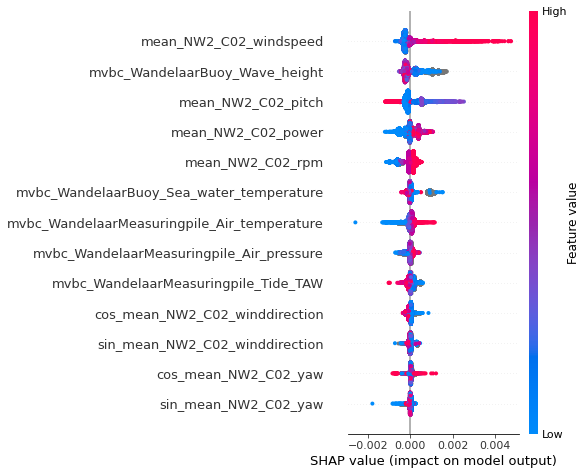

In [9]:
import mlflow
import shap

images_path = \
        '/'.join(
            [
                "C:/Users/Max/Documents/OWI_LAB/Code/Packages/oma_tracking/visualizations/",
                "nw2",
                location,
                "shap",
                "removed_harmonics"
            ])

for mode in tracked_frequencies.columns:
    print(mode)
    model = models[mode]['regressor']
    explainer = shap.TreeExplainer(model)
    shap_value = explainer.shap_values(models[mode]['preprocessing_angles'].transform(inputs))

    fig_local_path = images_path + '/' + 'mpe_' + name_location + '_' + mode + '_normalization' +  '_shap_summary_plot.png'
    shap.summary_plot(shap_value, models[mode]['preprocessing_angles'].transform(inputs), show=False)

    plt.gcf().axes[-1].set_aspect('auto')
    plt.tight_layout()
    plt.gcf().axes[-1].set_box_aspect(50)
    fig = plt.gcf()
    fig.savefig(fig_local_path)
    plt.show()
    plt.close()

In [ ]:
for mode in tracked_frequencies.columns:
    fig_local_path = images_path + '/' + 'mpe_' + name_location + '_' + mode + '_normalization' +  '_shap_summary_plot.png'
    run_id = rund_ids[mode]
    print(run_id)
    with mlflow.start_run(run_id):
        mlflow.log_artifacts(
            fig_local_path,
            'figures')
    mlflow.end_run()
    print('figure_uploaded')